<a href="https://colab.research.google.com/github/angus-lherrou/ling131-project/blob/master/preprocess_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import os
import warnings

from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_log_error


pd.set_option("max_columns", 500)


# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle
#make kaggle directory
!mkdir .kaggle




mkdir: cannot create directory ‘.kaggle’: File exists


In [0]:
import json

#token = {YOUR API TOKE HERE}
token = {"username":"craigtattan","key":"476b7dc16bfb763d97a6d5fe6f238191"}

with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)



In [0]:
%cd .kaggle
!ls
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

/content/.kaggle
'{'   kaggle.json
- path is now set to: {/content}


In [0]:
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c ashrae-energy-prediction

weather_train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
weather_test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
building_metadata.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
#compress data

def compress_df(df):
    result = df.copy()
    start_mem = df.memory_usage().sum() / 1024**2
    for col in result.columns:      
        col_data = result[col]
        dn = col_data.dtype.name  
        #this converts timestamp and primary use to numerical data
        if dn == "datetime64[ns]":
            continue
        if dn == "object":  
            result[col] = pd.to_numeric(col_data.astype("category").cat.codes, downcast="integer")
        elif dn == "bool":
            result[col] = col_data.astype("int8")
        elif dn.startswith("int") or (col_data.round() == col_data).all():
            result[col] = pd.to_numeric(col_data, downcast="integer")
        else:
            result[col] = pd.to_numeric(col_data, downcast='float')
    end_mem = result.memory_usage().sum() / 1024**2
    print('start :' + str(start_mem))
    print('end :' + str(end_mem))
    return result


#Read in the data

import gc

print('Reading')
print('...')

building_df = pd.read_csv('{/content}/competitions/ashrae-energy-prediction/building_metadata.csv')
weather_train = pd.read_csv('{/content}/competitions/ashrae-energy-prediction/weather_train.csv.zip', parse_dates=['timestamp'])
weather_test = pd.read_csv('{/content}/competitions/ashrae-energy-prediction/weather_test.csv.zip', parse_dates=['timestamp'])
train_df = pd.read_csv('{/content}/competitions/ashrae-energy-prediction/train.csv.zip', parse_dates=['timestamp'])
test_df = pd.read_csv('{/content}/competitions/ashrae-energy-prediction/test.csv.zip', parse_dates=['timestamp'])

print('Done')

compressed_train = compress_df(train_df)
compressed_weather = compress_df(weather_train)
compressed_build = compress_df(building_df)

compressed_test_weather = compress_df(weather_test)
compressed_test = compress_df(test_df)

del train_df, weather_train, building_df, weather_test, test_df
gc.collect()

Reading
...
Done
start :616.946533203125
end :289.19375228881836
start :9.597572326660156
end :4.932145118713379
start :0.0664520263671875
end :0.0222320556640625
start :19.036888122558594
end :9.782904624938965
start :1272.5098876953125
end :596.4890747070312


0

Next we can look at what data is missing in each of weather, building and train training sets.

In [0]:
total = compressed_weather.isnull().sum().sort_values(ascending = False)
percent = (compressed_weather.isnull().sum()/compressed_weather.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(17)

,Total,Percent
cloud_coverage,69173,49.489529
precip_depth_1_hr,50289,35.979052
sea_level_pressure,10618,7.596603
wind_direction,6268,4.484414
wind_speed,304,0.217496
dew_temperature,113,0.080845
air_temperature,55,0.039350
timestamp,0,0.000000
site_id,0,0.000000


In [0]:
total = compressed_train.isnull().sum().sort_values(ascending = False)
percent = (compressed_train.isnull().sum()/compressed_train.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(22)

,Total,Percent
meter_reading,0,0.0
timestamp,0,0.0
meter,0,0.0
building_id,0,0.0


In [0]:
total = compressed_build.isnull().sum().sort_values(ascending = False)
percent = (compressed_build.isnull().sum()/compressed_build.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(17)

,Total,Percent
floor_count,1094,75.500345
year_built,774,53.416149
square_feet,0,0.000000
primary_use,0,0.000000
building_id,0,0.000000
site_id,0,0.000000


In [0]:
total = compressed_test_weather.isnull().sum().sort_values(ascending = False)
percent = (compressed_test_weather.isnull().sum()/compressed_test_weather.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(17)

,Total,Percent
cloud_coverage,140448,50.658808
precip_depth_1_hr,95588,34.478057
sea_level_pressure,21265,7.670167
wind_direction,12370,4.461790
wind_speed,460,0.165919
dew_temperature,327,0.117947
air_temperature,104,0.037512
timestamp,0,0.000000
site_id,0,0.000000


In [0]:
total = compressed_test.isnull().sum().sort_values(ascending = False)
percent = (compressed_test.isnull().sum()/compressed_test.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(22)

,Total,Percent
timestamp,0,0.0
meter,0,0.0
building_id,0,0.0
row_id,0,0.0


We see in the weather data we are missing 49.5% of cloud_coverage, 36% of percip_depth_1hr, 7.6% of sea_level_pressure and 4.5% of wind_direction. 

We need to handle these missing values. We can fill them in with a constant, but this would create a bias. We could delete rows with missing data, but this would remove too many samples.

Our best option is to use **regression for interpolation. **

We may also want to look at correlations between these features before we begin.


# NaN Values 

Now we know that we have a significant amount of NaN values in weather and building data. We will impute this data using regression vie scikit learn's ItterativeImputer.

We need to get a list of the label names for features that have NaN data. Itterative imputer will return an np array without label names, we'll use our list to rebuild a dataframe with labels, we'll want these later te evaluate feature importance.

Next, we will one hot encode the data so taht it will work with our imputer.

One we have imputed building and weather data, we will merge all three datasets.

After we have merged we will deal with outliers in the next section.

**Steps:**

(1) we will look at NaN features

(2) Next we want to look for patterns in each site to identify unusual patterns and outliers.

We can see that we have a significant amount of missing data for some features.

How can we handle this missing data?

*   How prevalent is the missing data?
*   Is missing data random or does it have a pattern?

We don't want to miss a bias that may be present in missing data.
And
we don't want to create bias when we handle mmissing data.

If we delete rows - we will lose too many samples. 82% of floor count data is missing. Do we want to interpolate this? Or should we delete the column?

If we fill these rows with zeros ... # explain this further

The best option is to impute the missing data.

There are several methods for missing data imputation as discussed in (cite paper here). Some considerations we need to make include: ...

Talk about scikit learn library here.

In [0]:
#Get list of features with NaN values in weather, build data
nan_weather_train = [var for var in compressed_weather.columns.values if compressed_weather[var].isna().any()]
nan_build = [var for var in compressed_build.columns.values if compressed_build[var].isna().any()]
nan_weather_test = [var for var in compressed_test_weather.columns.values if compressed_test_weather[var].isna().any()]

In [0]:
def preprocess(df, date_string):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['seconds'] = (df['timestamp'] - pd.to_datetime(date_string)).dt.total_seconds() 
    print(df.dtypes.value_counts())
    print(df.select_dtypes('object').apply(pd.Series.nunique, axis = 0))

In [0]:
'One hot encoding for imputation'

building_categorical = ['site_id', 'primary_use']
weather_categorical  = ['site_id']



#preprocess the datasets for time
preprocess(compressed_weather, "2016-01-01")
preprocess(compressed_train, "2016-01-01")
preprocess(compressed_test, "2017-01-01")
preprocess(compressed_test_weather, "2017-01-01")


#One hot encode train, weather and building
def one_hot(df, categorical_vars):
    for var in categorical_vars:
      print('Fitting: ' + var)
      df = pd.concat([df, pd.get_dummies(df[var], prefix=var + '_')], axis=1)
      df.drop([var], axis=1, inplace=True)
    return df

compressed_weather = one_hot(compressed_weather, weather_categorical)
compressed_build = one_hot(compressed_build, building_categorical)
compressed_weather_test = one_hot(compressed_test_weather, weather_categorical)


#make a copy so we can keep labels after imputing
building_impute = compressed_build.copy()
weather_impute  = compressed_weather.copy()
weather_test_impute = compressed_test_weather.copy()


float32           7
datetime64[ns]    1
int8              1
float64           1
dtype: int64
Series([], dtype: float64)
datetime64[ns]    1
float32           1
int16             1
int8              1
float64           1
dtype: int64
Series([], dtype: float64)
datetime64[ns]    1
float64           1
int32             1
int16             1
int8              1
dtype: int64
Series([], dtype: float64)
float32           7
datetime64[ns]    1
int8              1
float64           1
dtype: int64
Series([], dtype: float64)
Fitting: site_id
Fitting: site_id
Fitting: primary_use
Fitting: site_id


In [0]:
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

weather_impute['timestamp'] = 0
imputer = IterativeImputer(random_state=42)
imputer.fit(weather_impute)
imputed = pd.DataFrame(imputer.transform(weather_impute))

#replace NaN columns in compressed_weather with new imputed columns
for val in nan_weather_train:
  compressed_weather[val] = imputed[list(weather_impute.columns.values).index(val)]


del imputed, weather_impute
gc.collect()


10

In [0]:
weather_test_impute['timestamp'] = 0
imputer = IterativeImputer(random_state=42)
imputer.fit(weather_test_impute)
imputed = pd.DataFrame(imputer.transform(weather_test_impute))

#replace NaN columns in compressed_weather with new imputed columns
for val in nan_weather_test:
  compressed_test_weather[val] = imputed[list(weather_test_impute.columns.values).index(val)]


del imputed, weather_test_impute
gc.collect()


22

In [0]:
imputer = IterativeImputer(random_state=42)
imputer.fit(building_impute)
imputed = pd.DataFrame(imputer.transform(building_impute))

#replace NaN columns in compressed_weather with new imputed columns
for val in nan_build:
  compressed_build[val] = imputed[list(building_impute.columns.values).index(val)]


In [0]:
del imputed, building_impute
gc.collect()

169

In [0]:
#merge train data

#get vars to merge on
site_ids = [feat for feat in compressed_build.columns.values if 'site_id' in feat]

print('Merging data')
print('...')

train_df = compressed_train.merge(compressed_build, on='building_id', how='left')
train_df = train_df.merge(compressed_weather, on=site_ids + ['timestamp', 'seconds'], how='left')



print('Done')

#write out test data, we will get it later and merge it when we are ready to test
# compressed_weather_test.to_csv('compressed_weather_test.csv')
# compressed_test.to_csv('compressed_test.csv')

#del compressed_train, compressed_weather, compressed_test, compressed_weather_test
gc.collect()

Merging data
...
Done


0

So what have we done so far?

We first compressed the data in each of the trainind files.

We added 
Next we one-hot encoded all categirical variables (except building id) and imputed missing values.

We merged our imputed dataset into one large dataset.

Now, we want to drop 'bad rows'. We have rows with zero meter readings and some outliers that we previously identified, let's take care of those now.

In [0]:
train_df['dayofweek'] = train_df['timestamp'].dt.dayofweek
#test_df = pd.concat([test_df, pd.get_dummies(test_df['dayofweek'], prefix='dayofweek _')], axis=1)
#test_df.drop(['dayofweek'], axis=1, inplace=True)

#Drop 1099

train_df = train_df[train_df['building_id'] != 1099]


#handle bad rows from site zero meter readings
site_0  = train_df[train_df.site_id__0 == 1]
train_df = train_df[train_df.site_id__0 != 1]

site_0['month'] = site_0['timestamp'].dt.month
site_0 = site_0[site_0.month != 1]
site_0 = site_0[site_0.month != 2]
site_0 = site_0[site_0.month != 3]

site_0.drop(['month'], axis=1)

train_df.append(site_0, ignore_index=True)

del site_0
gc.collect()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


0

In [0]:
\

In [0]:
train_df['meter_reading_log1p'] = np.log1p(train_df['meter_reading'])
#train_df.to_csv('train_merge.csv')

In [0]:
#del train_df
gc.collect()

0

In [0]:
#get preprocessed test data

#compressed_test = pd.read_csv('compressed_test.csv')
#compressed_weather_test = pd.read_csv('compressed_weather_test.csv')

#merge test data
print('Merging data')
print('...')

test_df = compressed_test.merge(compressed_build, on='building_id', how='left')
test_df = test_df.merge(compressed_weather_test, on=site_ids + ['timestamp', 'seconds'], how='left')



print('Done')

del compressed_test, compressed_weather_test
gc.collect()

#add day of week (-- and one hot?)

test_df['dayofweek'] = test_df['timestamp'].dt.dayofweek
#train_df = pd.concat([train_df, pd.get_dummies(train_df['dayofweek'], prefix='dayofweek _')], axis=1)
#train_df.drop(['dayofweek'], axis=1, inplace=True)


Merging data
...
Done


In [0]:
total = test_df.isnull().sum().sort_values(ascending = False)
percent = (test_df.isnull().sum()/test_df.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(22)

In [0]:
test_df.head()

,row_id,building_id,meter,timestamp,seconds,square_feet,year_built,floor_count,site_id__0,site_id__1,site_id__2,site_id__3,site_id__4,site_id__5,site_id__6,site_id__7,site_id__8,site_id__9,site_id__10,site_id__11,site_id__12,site_id__13,site_id__14,site_id__15,primary_use__0,primary_use__1,primary_use__2,primary_use__3,primary_use__4,primary_use__5,primary_use__6,primary_use__7,primary_use__8,primary_use__9,primary_use__10,primary_use__11,primary_use__12,primary_use__13,primary_use__14,primary_use__15,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,dayofweek
0,0,0,0,2017-01-01,0.0,7432,2008.0,7.241033,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17.799999,4.0,11.7,NaN,1021.400024,100.0,3.6,6
1,1,1,0,2017-01-01,0.0,2720,2004.0,7.133404,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17.799999,4.0,11.7,NaN,1021.400024,100.0,3.6,6
2,2,2,0,2017-01-01,0.0,5376,1991.0,7.043626,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17.799999,4.0,11.7,NaN,1021.400024,100.0,3.6,6
3,3,3,0,2017-01-01,0.0,23685,2002.0,7.393734,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17.799999,4.0,11.7,NaN,1021.400024,100.0,3.6,6
4,4,4,0,2017-01-01,0.0,116607,1975.0,8.419974,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17.799999,4.0,11.7,NaN,1021.400024,100.0,3.6,6


# LGBM


Establish the categorical and feature columns that are going to be utilized by the model

In [0]:
category_cols = ['building_id']  # , 'meter'
feature_cols = ['square_feet', 'year_built'] + [
    'dayofweek', 'seconds'] + [
    'air_temperature', 'cloud_coverage',
    'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
    'wind_direction', 'wind_speed'] + ['site_id__0','site_id__1','site_id__2','site_id__3','site_id__4','site_id__5',
                                       'site_id__6','site_id__7','site_id__8','site_id__9','site_id__10','site_id__11','site_id__12',
                                       'site_id__13','site_id__14','site_id__15'] + ['primary_use__0','primary_use__1','primary_use__2','primary_use__3',
                                       'primary_use__4','primary_use__5','primary_use__6','primary_use__7','primary_use__8','primary_use__9','primary_use__10','primary_use__11','primary_use__12',
                                       'primary_use__13','primary_use__14','primary_use__15']


Create the X and Y training sets for the particular meter type

In [0]:
def create_X_y(train_df, target_meter):
    target_train_df = train_df[train_df['meter'] == target_meter]
    # target_train_df = target_train_df.merge(building_meta_df, on='building_id', how='left')
    # target_train_df = target_train_df.merge(weather_train_df, on=['site_id', 'timestamp'], how='left')
    X_train = target_train_df[feature_cols + category_cols]
    y_train = target_train_df['meter_reading_log1p'].values

    del target_train_df
    return X_train, y_train

Method for fitting the training sets into a lgbm model

In [0]:
import lightgbm as lgb

def fit_lgbm(train, val, devices=(-1,), seed=None, cat_features=None, num_rounds=1500, lr=0.1, bf=0.1):
    #Establishing sets of training data and test data for model (valid==test)
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'l2'
    #Parameters for our model
    params = {'num_leaves': 31,
              'objective': 'regression',
              'learning_rate': lr,
              "boosting": "gbdt",
              "bagging_freq": 5,
              "bagging_fraction": bf,
              "feature_fraction": 0.9,
              "metric": metric,
              }
              
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})

    params['seed'] = seed

    early_stop = 20
    verbose_eval = 20

    #Creating lgbm dataset versions
    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]

    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)
    

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    
    print('best_score', model.best_score)
    log = {'train/mae': model.best_score['training']['l2'],
           'valid/mae': model.best_score['valid_1']['l2']}
    return model, y_pred_valid, log


In [0]:
import pickle



Cross Validation Portion

In [0]:
import numpy as np
from sklearn.model_selection import KFold

folds = 2
seed = 1
shuffle = False
kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

Training for the electricity meter type

target_meter 0 (11143719, 44)
cat_features [43]
train 5571859 valid 5571860
training LGB:


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.726644	valid_1's l2: 0.827855
[40]	training's l2: 0.426147	valid_1's l2: 0.721747
Early stopping, best iteration is:
[32]	training's l2: 0.487498	valid_1's l2: 0.676584
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.48749762222011184}, 'valid_1': {'l2': 0.6765836522972911}})
train 5571860 valid 5571859
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.662274	valid_1's l2: 0.868426
[40]	training's l2: 0.359202	valid_1's l2: 0.93597
Early stopping, best iteration is:
[27]	training's l2: 0.486173	valid_1's l2: 0.816379
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.48617269047493333}, 'valid_1': {'l2': 0.8163791632511322}})


10

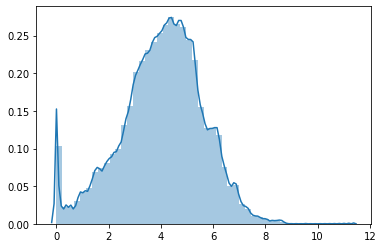

In [0]:
import seaborn as sns
target_meter = 0
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])
gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models0 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols,
                                        num_rounds=1000, lr=0.05, bf=0.7)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models0.append(model)
    gc.collect()

sns.distplot(y_train)
del X_train, y_train
gc.collect()

Training for the chilled water meter type

target_meter 1 (4014187, 44)
cat_features [43]
train 2007093 valid 2007094
training LGB:


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 2.25716	valid_1's l2: 3.0353
[40]	training's l2: 1.54065	valid_1's l2: 2.6069
[60]	training's l2: 1.2962	valid_1's l2: 2.5891
[80]	training's l2: 1.18037	valid_1's l2: 2.56981
[100]	training's l2: 1.10833	valid_1's l2: 2.57908
Early stopping, best iteration is:
[81]	training's l2: 1.17752	valid_1's l2: 2.56677
best_score defaultdict(<class 'dict'>, {'training': {'l2': 1.1775162270148771}, 'valid_1': {'l2': 2.5667699120412264}})
train 2007094 valid 2007093
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 2.16207	valid_1's l2: 3.98583
[40]	training's l2: 1.40782	valid_1's l2: 4.4516
Early stopping, best iteration is:
[21]	training's l2: 2.09185	valid_1's l2: 3.91512
best_score defaultdict(<class 'dict'>, {'training': {'l2': 2.091854287710204}, 'valid_1': {'l2': 3.915117628813213}})


10

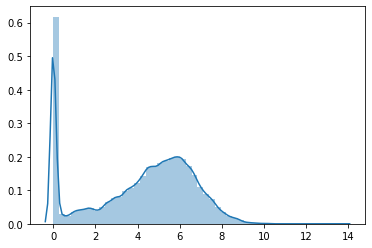

In [0]:
target_meter = 1
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])
gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models1 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols, num_rounds=1000,
                                       lr=0.05, bf=0.5)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models1.append(model)
    gc.collect()


sns.distplot(y_train)
del X_train, y_train
gc.collect()

Training for the steam meter type

target_meter 2 (2699929, 44)
cat_features [43]
train 1349964 valid 1349965
training LGB:


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 2.38814	valid_1's l2: 3.42145
[40]	training's l2: 1.55199	valid_1's l2: 3.17139
[60]	training's l2: 1.31268	valid_1's l2: 3.13691
[80]	training's l2: 1.21428	valid_1's l2: 3.06815
[100]	training's l2: 1.15222	valid_1's l2: 3.05079
[120]	training's l2: 1.11634	valid_1's l2: 3.03663
[140]	training's l2: 1.08203	valid_1's l2: 3.03743
Early stopping, best iteration is:
[128]	training's l2: 1.09914	valid_1's l2: 3.02754
best_score defaultdict(<class 'dict'>, {'training': {'l2': 1.0991405837531072}, 'valid_1': {'l2': 3.027535279222967}})
train 1349965 valid 1349964
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 2.45648	valid_1's l2: 3.0686
[40]	training's l2: 1.61733	valid_1's l2: 2.58198
[60]	training's l2: 1.37494	valid_1's l2: 2.52937
[80]	training's l2: 1.26466	valid_1's l2: 2.51414
[100]	training's l2: 1.19893	valid_1's l2: 2.50468
[120]	training's l2: 1.143

10

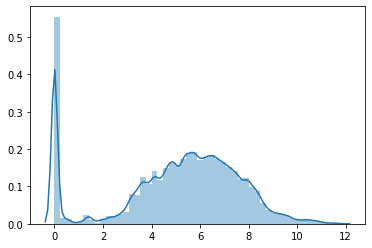

In [0]:
target_meter = 2
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])

gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models2 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols,
                                        num_rounds=1000, lr=0.05, bf=0.8)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models2.append(model)
    gc.collect()

sns.distplot(y_train)
del X_train, y_train
gc.collect()

Training for the hot water meter type

target_meter 3 (1264037, 44)
cat_features [43]
train 632018 valid 632019
training LGB:


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 3.43945	valid_1's l2: 4.87617
[40]	training's l2: 2.33954	valid_1's l2: 4.30333
[60]	training's l2: 1.95697	valid_1's l2: 4.19718
Early stopping, best iteration is:
[57]	training's l2: 2.00048	valid_1's l2: 4.17384
best_score defaultdict(<class 'dict'>, {'training': {'l2': 2.000480360318138}, 'valid_1': {'l2': 4.173835014810186}})
train 632019 valid 632018
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 3.23884	valid_1's l2: 4.32684
[40]	training's l2: 2.1643	valid_1's l2: 3.42664
[60]	training's l2: 1.79562	valid_1's l2: 3.15602
[80]	training's l2: 1.60574	valid_1's l2: 3.07258
[100]	training's l2: 1.50631	valid_1's l2: 3.04671
[120]	training's l2: 1.45155	valid_1's l2: 3.03964
Early stopping, best iteration is:
[108]	training's l2: 1.48389	valid_1's l2: 3.03328
best_score defaultdict(<class 'dict'>, {'training': {'l2': 1.483886262036968}, 'valid_1': {'l2':

10

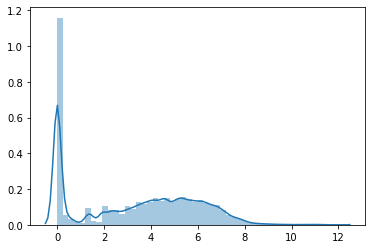

In [0]:
target_meter = 3
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])

gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models3 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols, num_rounds=1000,lr=0.03, bf=0.9)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models3.append(model)
    gc.collect()


sns.distplot(y_train)
del X_train, y_train
gc.collect()
                                        

Utilizing model on the test data

In [0]:
def create_X(test_df, target_meter):
    target_test_df = test_df[test_df['meter'] == target_meter]
    # target_test_df = target_test_df.merge(building_meta_df, on='building_id', how='left')
    # target_test_df = target_test_df.merge(weather_test_df, on=['site_id', 'timestamp'], how='left')
    X_test = target_test_df[feature_cols + category_cols]
    return X_test

In [0]:
from tqdm import tqdm
def pred(X_test, models, batch_size=1000000):
    iterations = (X_test.shape[0] + batch_size -1) // batch_size
    print('iterations', iterations)

    y_test_pred_total = np.zeros(X_test.shape[0])
    for i, model in enumerate(models):
        print(f'predicting {i}-th model')
        for k in tqdm(range(iterations)):
            y_pred_test = model.predict(X_test[k*batch_size:(k+1)*batch_size], num_iteration=model.best_iteration)
            y_test_pred_total[k*batch_size:(k+1)*batch_size] += y_pred_test

    y_test_pred_total /= len(models)
    return y_test_pred_total

  0%|          | 0/25 [00:00<?, ?it/s]

iterations 25
predicting 0-th model


  0%|          | 0/25 [00:00<?, ?it/s]

predicting 1-th model


100%|██████████| 25/25 [00:31<00:00,  1.25s/it]


CPU times: user 3min 59s, sys: 284 ms, total: 4min
Wall time: 1min 23s


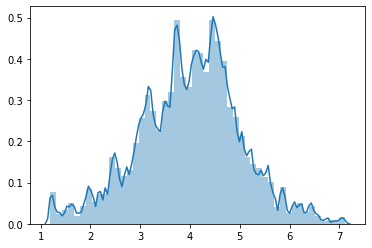

In [0]:
X_test = create_X(test_df, target_meter=0)
gc.collect()

y_test0 = pred(X_test, models0)

sns.distplot(y_test0)

gc.collect()


  0%|          | 0/9 [00:00<?, ?it/s]

iterations 9
predicting 0-th model


  0%|          | 0/9 [00:00<?, ?it/s]

predicting 1-th model


100%|██████████| 9/9 [00:08<00:00,  1.06it/s]


CPU times: user 1min 50s, sys: 115 ms, total: 1min 50s
Wall time: 37.2 s


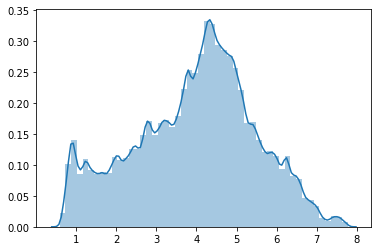

In [0]:
X_test = create_X(test_df, target_meter=1)
gc.collect()

y_test1 = pred(X_test, models1)
sns.distplot(y_test1)

del X_test
gc.collect()

  0%|          | 0/6 [00:00<?, ?it/s]

iterations 6
predicting 0-th model


  0%|          | 0/6 [00:00<?, ?it/s]

predicting 1-th model


100%|██████████| 6/6 [00:24<00:00,  3.94s/it]


14

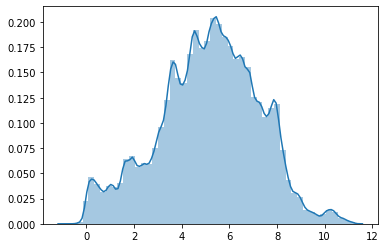

In [0]:
X_test = create_X(test_df, target_meter=2)
gc.collect()

y_test2 = pred(X_test, models2)
sns.distplot(y_test2)

del X_test
gc.collect()

  0%|          | 0/3 [00:00<?, ?it/s]

iterations 3
predicting 0-th model


  0%|          | 0/3 [00:00<?, ?it/s]

predicting 1-th model


100%|██████████| 3/3 [00:07<00:00,  2.42s/it]


14

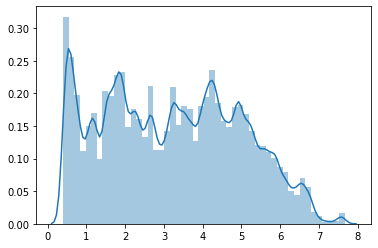

In [0]:
X_test = create_X(test_df, target_meter=3)
gc.collect()

y_test3 = pred(X_test, models3)
sns.distplot(y_test3)

del X_test
gc.collect()

In [0]:
submission_df = pd.read_csv('{/content}/competitions/ashrae-energy-prediction/sample_submission.csv.zip')

submission_df.loc[test_df['meter'] == 0, 'meter_reading'] = np.expm1(y_test0)
submission_df.loc[test_df['meter'] == 1, 'meter_reading'] = np.expm1(y_test1)
submission_df.loc[test_df['meter'] == 2, 'meter_reading'] = np.expm1(y_test2)
submission_df.loc[test_df['meter'] == 3, 'meter_reading'] = np.expm1(y_test3)

submission_df.to_csv('sample_submission.csv')

In [0]:
from google.colab import files 
files.download('sample_submission.csv')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 42934, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil